In [1]:
import torch
import torchvision
import pandas as pd
import numpy as np

import os
import albumentations # for augumentations
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from sklearn import metrics, model_selection
import cv2

%matplotlib inline

# Read the data


In [2]:
df_train_data = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
df_train_data

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [3]:
df_train_data.label.value_counts()

label
3    13158
4     2577
2     2386
1     2189
0     1087
Name: count, dtype: int64

In [4]:
df_train, df_valid = model_selection.train_test_split(df_train_data, test_size=0.1, random_state=109, stratify=df_train_data["label"].values)

df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)

In [5]:
df_train.shape, df_valid.shape

((19257, 2), (2140, 2))

In [6]:
image_path = "../input/cassava-leaf-disease-classification/train_images"
train_image_paths = [os.path.join(image_path, x) for x in df_train["image_id"].values]
valid_image_paths = [os.path.join(image_path, x) for x in df_valid["image_id"].values]

len(train_image_paths), len(valid_image_paths), train_image_paths[:3]

(19257,
 2140,
 ['../input/cassava-leaf-disease-classification/train_images/2299589132.jpg',
  '../input/cassava-leaf-disease-classification/train_images/153749509.jpg',
  '../input/cassava-leaf-disease-classification/train_images/84269918.jpg'])

In [7]:
train_targets = df_train["label"].values
valid_targets = df_valid["label"].values

train_targets

array([3, 0, 4, ..., 3, 0, 3])

## Dataset and Dataloader class for our problem

In [8]:
class LeafImageDataset:
    def __init__(self, image_paths, targets, augumentations=None):
        self.image_paths = image_paths
        self.targets = targets
        self.augumentations = augumentations
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        target = self.targets[idx]
        image = cv2.imread(self.image_paths[idx])
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.augumentations is not None:
            augumented = self.augumentations(image=image)
            image = augumented["image"]
#             mask = augumented["mask"]
        image= np.transpose(image,(2,0,1)).astype(np.float32)
        return {
            "image" : torch.tensor(image),
#             "mask" : torch.tensor(mask),
            "target" : torch.tensor(target)
        }

In [9]:
train_dataset = LeafImageDataset(train_image_paths, train_targets)
train_dataset[0]
valid_dataset = LeafImageDataset(valid_image_paths, valid_targets)

3


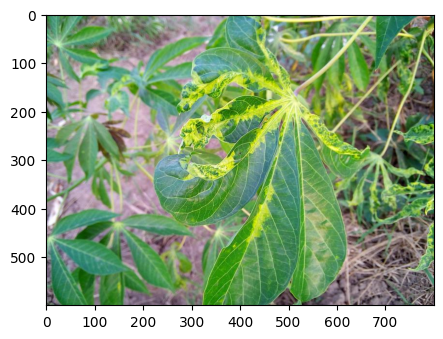

In [10]:
def plot_image(image_dict):
    img_tensor = image_dict["image"]
    target = image_dict["target"]
    print(target.item())
    plt.figure(figsize=(5,10))
    image = img_tensor.permute(1,2,0)/255
    plt.imshow(image)

plot_image(train_dataset[10])

1
2
3
0
4


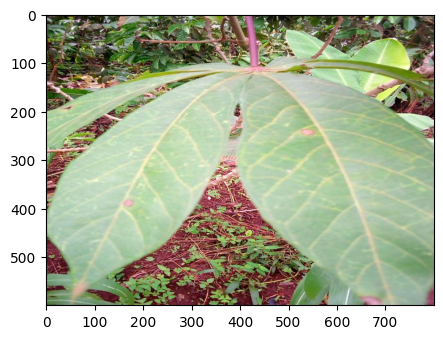

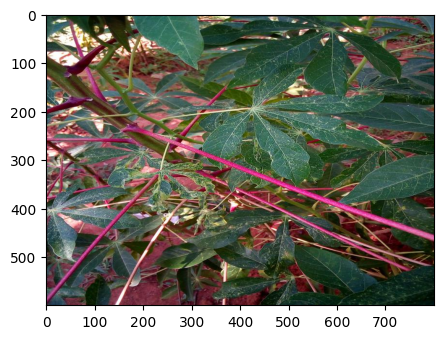

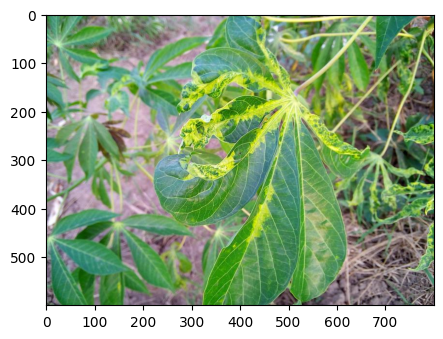

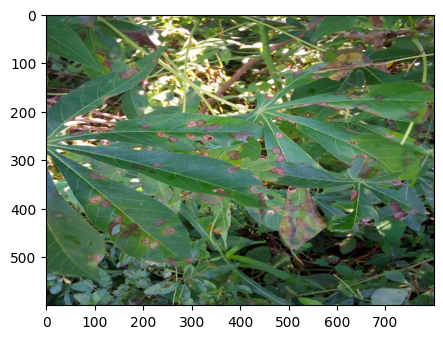

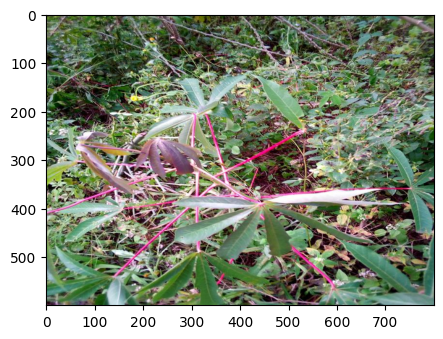

In [11]:
plot_image(train_dataset[6])
plot_image(train_dataset[3])
plot_image(train_dataset[10])
plot_image(train_dataset[1])
plot_image(train_dataset[5])

In [12]:
train_aug = albumentations.Compose(
[
    albumentations.RandomResizedCrop(256, 256),
    albumentations.Transpose(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5)
])


valid_aug = albumentations.Compose(
[
    albumentations.CenterCrop(256, 256, p=1.0),
    albumentations.Resize(256, 256),
    albumentations.Transpose(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5)
])


train_dataset = LeafImageDataset(train_image_paths, train_targets, augumentations=train_aug)
valid_dataset = LeafImageDataset(valid_image_paths, valid_targets, augumentations=valid_aug)
train_dataset[10]


{'image': tensor([[[158., 149., 145.,  ..., 156., 179., 139.],
          [147., 144., 142.,  ..., 124., 186., 156.],
          [150., 142., 138.,  ..., 106., 151., 170.],
          ...,
          [149., 156., 165.,  ...,  64.,  59.,  72.],
          [130., 139., 148.,  ...,  63.,  62.,  70.],
          [117., 125., 131.,  ...,  49.,  53.,  67.]],
 
         [[123., 118., 121.,  ..., 143., 166., 126.],
          [115., 117., 123.,  ..., 114., 176., 146.],
          [123., 120., 123.,  ...,  96., 141., 160.],
          ...,
          [162., 161., 160.,  ..., 131., 123., 132.],
          [167., 164., 161.,  ..., 126., 123., 129.],
          [169., 166., 161.,  ..., 111., 112., 126.]],
 
         [[142., 133., 130.,  ..., 151., 174., 134.],
          [131., 128., 124.,  ..., 112., 175., 147.],
          [135., 125., 119.,  ...,  95., 140., 161.],
          ...,
          [133., 148., 162.,  ...,  78.,  68.,  72.],
          [103., 122., 138.,  ...,  94.,  82.,  75.],
          [ 77.,  94.,

In [13]:
?torch.utils.data.DataLoader

Init signature:
torch.utils.data.DataLoader(
    dataset: torch.utils.data.dataset.Dataset[+T_co],
    batch_size: Optional[int] = 1,
    shuffle: Optional[bool] = None,
    sampler: Union[torch.utils.data.sampler.Sampler, Iterable, NoneType] = None,
    batch_sampler: Union[torch.utils.data.sampler.Sampler[List], Iterable[List], NoneType] = None,
    num_workers: int = 0,
    collate_fn: Optional[Callable[[List[~T]], Any]] = None,
    pin_memory: bool = False,
    drop_last: bool = False,
    timeout: float = 0,
    worker_init_fn: Optional[Callable[[int], NoneType]] = None,
    multiprocessing_context=None,
    generator=None,
    *,
    prefetch_factor: Optional[int] = None,
    persistent_workers: bool = False,
    pin_memory_device: str = '',
)
Docstring:     
Data loader. Combines a dataset and a sampler, and provides an iterable over
the given dataset.

The :class:`~torch.utils.data.DataLoader` supports both map-style and
iterable-style datasets with single- or multi-process loa

In [14]:
# Dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,num_workers=2 )
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64,num_workers=2 )


In [15]:
for data in train_loader:
    print(data["image"], data["target"])
    break

tensor([[[[146., 128., 121.,  ..., 196., 217., 205.],
          [110., 119., 142.,  ..., 200., 205., 211.],
          [124., 169., 173.,  ..., 192., 194., 193.],
          ...,
          [ 81.,  81.,  79.,  ..., 106.,  79.,  76.],
          [ 90.,  87.,  75.,  ...,  66.,  64.,  55.],
          [126.,  80.,  53.,  ...,  70.,  76.,  63.]],

         [[219., 201., 197.,  ..., 222., 242., 228.],
          [184., 191., 215.,  ..., 223., 227., 233.],
          [197., 240., 240.,  ..., 216., 216., 213.],
          ...,
          [ 58.,  60.,  63.,  ..., 153., 133., 133.],
          [ 63.,  64.,  61.,  ..., 111., 118., 111.],
          [ 97.,  55.,  42.,  ..., 116., 130., 119.]],

         [[ 77.,  48.,  34.,  ...,  66.,  86.,  77.],
          [ 46.,  43.,  55.,  ...,  61.,  66.,  78.],
          [ 63.,  97.,  89.,  ...,  49.,  51.,  55.],
          ...,
          [ 44.,  44.,  43.,  ..., 111.,  92.,  92.],
          [ 52.,  52.,  44.,  ...,  76.,  79.,  72.],
          [ 89.,  45.,  25.,  ...

# Train model for our data

In [16]:
# torchvision.models.resnet18(pretrained=False)

In [17]:
class LeafModel(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        self.convnet = torchvision.models.resnet18(pretrained=pretrained)
#         self.convnet = resnet18_model
        self.convnet.fc = nn.Linear(512, num_classes)
        self.step_scheduler_after = "epoch"
        
    def loss(self, outputs, targets):
        if targets is None:
            return None
        return nn.CrossEntropyLoss()(outputs, targets)
    
    def monitor_metrics(self, outputs, targets):
        outputs = torch.argmax(outputs, dim=1).cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        acc = metrics.accuracy_score(targets, outputs)
        return {
            "accuracy" : acc
        }
        
    def fetch_optimizer(self):
        opt = torch.optim.Adam(self.parameters(), lr=1e-3)
        return opt
    
    def fetch_scheduler(self, optimizer):
        sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
        return sch
        
    def forward(self, img, targets=None):
        outputs = self.convnet(img)
        loss = None
        metrics = {}
        if targets is not None:
            loss = self.loss(outputs, targets)
            metrics = self.monitor_metrics(outputs, targets)
        return outputs, loss, metrics
       
num_classes=df_train_data["label"].nunique()
model = LeafModel(num_classes=num_classes, pretrained=True)
model
        

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 67.4MB/s]


LeafModel(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [18]:
model.train

<bound method Module.train of LeafModel(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, mome

In [19]:
# trial
img_ = train_dataset[10]["image"].unsqueeze(0)
y_ = train_dataset[10]["target"].unsqueeze(0)
model(img_, y_)

(tensor([[ 0.0555,  0.3290,  0.8642,  0.0064, -0.5660]],
        grad_fn=<AddmmBackward0>),
 tensor(1.8490, grad_fn=<NllLossBackward0>),
 {'accuracy': 0.0})

In [20]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopper = EarlyStopper(patience=3, min_delta=10)


In [21]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Train on {device}")

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        

# train_losses = []
# valid_losses = []

# def train(model, train_dataset, valid_dataset, device, num_epochs=1, patience=3):
#     model.to(device)
#     optimizer = model.fetch_optimizer()
#     scheduler = model.fetch_scheduler(optimizer)
#     early_stopping = EarlyStopping(patience=patience)
    
#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0
        
#         for batch in train_dataset:
#             optimizer.zero_grad()
#             image = batch["image"].to(device)
#             target = batch["target"].to(device)
#             output, loss, acc = model(image, target)
#             loss.backward()
#             optimizer.step()

#             train_losses.append(loss.item())
#             train_loss += loss.item()
#         train_loss = train_loss / len(train_dataset)
        
#         model.eval()
#         valid_loss = 0
#         with torch.no_grad():
#             for batch_v in valid_dataset:
#                 image = batch_v["image"].to(device)
#                 target = batch_v["target"].to(device)
#                 output, loss, acc = model(image, target)
#                 valid_losses.append(oss.item())
#                 valid_loss += loss.item()
#         valid_loss = valid_loss / len(valid_dataset)

#         if model.step_scheduler_after == "epoch":
#             scheduler.step()
            
#         print(
#           f"Epoch : {epoch+1} / {num_epochs} ..",
#           f"Train loss : {train_loss:.3f} ",
#           f"Validation loss : {valid_loss:.3f} "
#         )
#         # Early stopping check
#         early_stopping(valid_loss)
#         if early_stopping.early_stop:
#             print("Early stopping triggered")
#             break

# train(model, train_loader, valid_loader, device=device, num_epochs=10)

Train on cuda


In [22]:

def train(model, train_dataset, valid_dataset, device, num_epochs=1, patience=3):
    model.to(device)
    optimizer = model.fetch_optimizer()
    scheduler = model.fetch_scheduler(optimizer)
    early_stopping = EarlyStopping(patience=patience)
    
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        
        for batch in train_dataset:
            optimizer.zero_grad()
            image = batch["image"].to(device)
            target = batch["target"].to(device)
            output, loss, acc = model(image, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Update training accuracy
            _, predicted = torch.max(output.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

        train_loss = train_loss / len(train_dataset)
        train_losses.append(train_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        model.eval()
        valid_loss = 0
        correct_valid = 0
        total_valid = 0
        
        with torch.no_grad():
            for batch_v in valid_dataset:
                image = batch_v["image"].to(device)
                target = batch_v["target"].to(device)
                output, loss, acc = model(image, target)
                valid_loss += loss.item()
                
                # Update validation accuracy
                _, predicted = torch.max(output.data, 1)
                total_valid += target.size(0)
                correct_valid += (predicted == target).sum().item()

        valid_loss = valid_loss / len(valid_dataset)
        valid_losses.append(valid_loss)
        valid_accuracy = 100 * correct_valid / total_valid
        valid_accuracies.append(valid_accuracy)

        if model.step_scheduler_after == "epoch":
            scheduler.step()
            
        print(
            f"Epoch : {epoch+1} / {num_epochs} ..",
            f"Train loss : {train_loss:.3f} ..",
            f"Train accuracy : {train_accuracy:.2f}% ..",
            f"Validation loss : {valid_loss:.3f} ..",
            f"Validation accuracy : {valid_accuracy:.2f}%"
        )

        # Early stopping check
        early_stopping(valid_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return train_losses, valid_losses, train_accuracies, valid_accuracies

#usage
train_losses, valid_losses, train_accuracies, valid_accuracies = train(model, train_loader, valid_loader, device=device, num_epochs=10)


Epoch : 1 / 10 .. Train loss : 0.764 .. Train accuracy : 72.24% .. Validation loss : 0.656 .. Validation accuracy : 76.12%
Epoch : 2 / 10 .. Train loss : 0.595 .. Train accuracy : 78.74% .. Validation loss : 0.632 .. Validation accuracy : 76.78%
Epoch : 3 / 10 .. Train loss : 0.537 .. Train accuracy : 80.98% .. Validation loss : 0.587 .. Validation accuracy : 79.72%
Epoch : 4 / 10 .. Train loss : 0.495 .. Train accuracy : 82.45% .. Validation loss : 0.506 .. Validation accuracy : 81.87%
Epoch : 5 / 10 .. Train loss : 0.468 .. Train accuracy : 83.48% .. Validation loss : 0.435 .. Validation accuracy : 84.58%
Epoch : 6 / 10 .. Train loss : 0.447 .. Train accuracy : 84.19% .. Validation loss : 0.427 .. Validation accuracy : 84.95%
Epoch : 7 / 10 .. Train loss : 0.434 .. Train accuracy : 84.71% .. Validation loss : 0.420 .. Validation accuracy : 84.77%
Epoch : 8 / 10 .. Train loss : 0.424 .. Train accuracy : 85.07% .. Validation loss : 0.410 .. Validation accuracy : 84.86%
Epoch : 9 / 10 .

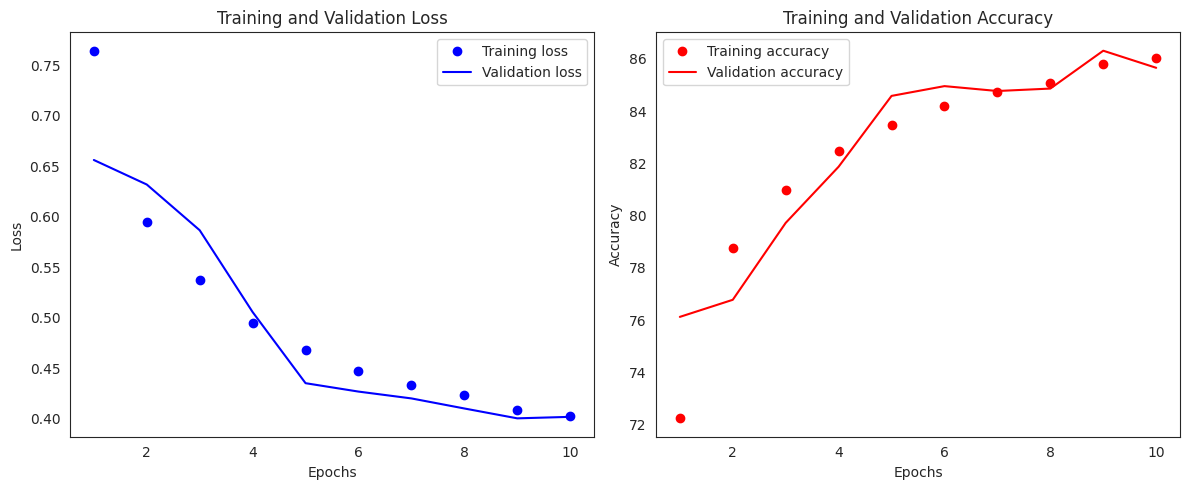

In [32]:

def plot_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo', label='Training loss')
    plt.plot(epochs, valid_losses, 'b-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'ro', label='Training accuracy')
    plt.plot(epochs, valid_accuracies, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies)

In [25]:
test_df_data = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv")
image_path = "../input/cassava-leaf-disease-classification/test_images/"
test_image_paths = [
    os.path.join(image_path, x) for x in test_df_data["image_id"].values
]


test_aug = albumentations.Compose(
[
    albumentations.CenterCrop(256, 256, p=1.0),
    albumentations.Resize(256, 256),
    albumentations.Transpose(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5)
])

test_targets = test_df_data["label"].values

test_dataset = LeafImageDataset(test_image_paths, test_targets, augumentations=valid_aug)

test_loader = torch.utils.data.DataLoader(test_dataset)

In [26]:
test_df_data

,image_id,label
0,2216849948.jpg,4


In [35]:

def test(model, test_loader, device):
    model.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    final_pred = None
    with torch.no_grad():
        for batch in test_loader:
            image = batch["image"].to(device)
            target = batch["target"].to(device)
            output, loss, _ = model(image, target)
            test_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            if final_pred is None:
                final_pred = pred.item()
            else:
                final_pred = np.vstack((final_pred, pred.item()))
            correct += (pred == target).sum().item()
            total += target.size(0)
    
    test_loss /= len(test_loader)
    accuracy = correct / total
    
    print(f"Test loss: {test_loss:.3f}, Test accuracy: {accuracy:.3f}")
    
    return final_pred, test_loss, accuracy

final_preds, test_loss, test_accuracy = test(model, test_loader, device=device)

Test loss: 0.656, Test accuracy: 1.000
